In [1]:
import tensorflow as tf
import os
import cv2
import shutil
import random
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
base_path = '../../datasets/'
data_dir = os.path.join(base_path, 'to_train')

dataset_path = os.path.join(data_dir, 'preprocessed')
train_path = os.path.join(data_dir, 'training')
valid_path = os.path.join(data_dir, 'validation')
testing_path = os.path.join(data_dir, 'testing')

In [3]:
class_names = []
split_ratio = 0.2
num_files_to_move = 2
validation_file = 2

In [4]:
def face_detect(img, path):
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Load the cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5, minSize=(200, 200))

    if len(faces) > 0:
      x, y, w, h = faces[0]  # Menggunakan wajah pertama yang terdeteksi
      # cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
      face = img[y:y+h, x:x+w]  # Memotong bagian wajah

      if face.size > 0:
        face = cv2.resize(face, (224, 224))
        cv2.imwrite(path, face)
        return True
      else:
        print("Area Wajah Tidak Terdeteksi " + path)
        return False
    else:
      print("Wajah Tidak Terdeteksi " + path)
      return False

In [5]:
def random_erasing(image, sl=0.005, sh=0.05, aspect_ratio=1):

    img_h, img_w, img_c = image.shape
    area = img_h * img_w

    target_area = np.random.uniform(sl, sh) * area

    w = h = int(round(np.sqrt(target_area / aspect_ratio)))

    if h < img_h and w < img_w:
        x1 = np.random.randint(0, img_h - h)
        y1 = np.random.randint(0, img_w - w)
        if img_c == 3:
            image[x1:x1+h, y1:y1+w, :] = 0
        else:
            image[x1:x1+h, y1:y1+w, 0] = 0
    return image

In [6]:
def preprocess_training(path):
   for folder in os.listdir(path):
      folder_path = os.path.join(path, folder)
      files = os.listdir(folder_path)

      for file in files:
         file_path = os.path.join(folder_path, file)
         img = load_img(file_path)
         img_array = img_to_array(img)
         preprocessed_image = tf.keras.applications.resnet.preprocess_input(
             img_array)
         tf.keras.utils.save_img(file_path, preprocessed_image)

In [7]:
def histogram_equalization(img):
    return cv2.equalizeHist(img)


def logarithmic_transform(img):
    c = 255 / np.log(1 + np.max(img))
    log_image = c * (np.log(img + 1))
    log_image = np.array(log_image, dtype=np.uint8)
    return log_image


def gamma_correction(img, gamma):
    inv_gamma = 1 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) *
                     255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)


In [8]:
def preprocess_testing(path):
   for file in os.listdir(path):
      file_path = os.path.join(path, file)
      # img = load_img(file_path)
      # img_array = img_to_array(img)
      # preprocessed_image = tf.keras.applications.resnet.preprocess_input(
      #       img_array)
      # tf.keras.utils.save_img(file_path, preprocessed_image)

      image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
      cv2.imwrite(file_path, image)

In [137]:
def aug_random_erasing(path):

  for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)

    for file in os.listdir(folder_path):
      file_path = os.path.join(folder_path, file)

      for j in range(1, 5):
          name = file.split('.')
          aug_file_name = name[0] + '_aug_' + str(j) + '.' + name[1]
          aug_file_path = os.path.join(folder_path, aug_file_name)
          image = cv2.imread(file_path)
          image = np.copy(image)
          if np.random.rand() < 0.5:
              image = cv2.flip(image, 1)
          augmented_image = random_erasing(image)

          cv2.imwrite(aug_file_path, augmented_image)

In [10]:
def split_train_validation(train_path, validation_path, split_ratio):
   if not os.path.exists(validation_path):
      os.makedirs(validation_path)

   for folder in os.listdir(train_path):
      folder_path = os.path.join(train_path, folder)
      valid_folder_path = os.path.join(validation_path, folder)
      if not os.path.exists(valid_folder_path):
         os.makedirs(valid_folder_path)

      files = os.listdir(folder_path)
      file_to_move = int(len(files) * split_ratio)
      random.shuffle(files)
      for i, file in enumerate(files):
         file_path = os.path.join(folder_path, file)
         target_path = os.path.join(valid_folder_path, file)
         shutil.copy(file_path, target_path)
         os.remove(file_path)
         if i == file_to_move:
            break

In [130]:
def preprocess(path):
   for folder in os.listdir(path):
      folder_path = os.path.join(path, folder)
      for i, file in enumerate(os.listdir(folder_path)):
         name = file.split('.')
         eks = name[1]
         file_path = os.path.join(folder_path, file)
         file_name = folder + '-' + str(i) + '.' + eks
         target_folder = os.path.join(path, folder)

         image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
         # image = cv2.resize(image, (56, 56))

         gamma_augmented(image, file, target_folder)
         os.remove(file_path)

In [12]:
def random_rotation(image):

    # Tentukan sudut rotasi acak antara -30 dan 30 derajat
    angle = np.random.uniform(-20, 20)

    # Hitung pusat rotasi
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    # Buat matriks rotasi
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Terapkan rotasi pada gambar
    rotated_img = cv2.warpAffine(image, rotation_matrix, (width, height))

    if np.random.rand() < 0.5:
        rotated_img = cv2.flip(rotated_img, 1)

    return rotated_img

In [13]:
def merge_to_preprocessed():
   
   for set in os.listdir(data_dir):
      set_path = os.path.join(data_dir, set)
      
      for folder in os.listdir(set_path):
         folder_path = os.path.join(set_path, folder)
         target_folder = os.path.join(data_dir, 'preprocessed', folder)
         
         if not os.path.exists(target_folder):
            os.makedirs(target_folder)
         
         for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            new_file_path = os.path.join(target_folder, file)
            
            img = cv2.imread(file_path)
            
            img = cv2.resize(img, (224,224))
            
            cv2.imwrite(new_file_path, img)
            # shutil.copy(file_path, new_file_path)

In [132]:
def gamma_augmented(img, file_name, target_folder, gamma=1.0):
   name = file_name.split('.')

   img_hist_eq = histogram_equalization(img)
   img_log_transform = logarithmic_transform(img)
   img_gamma_corrected = gamma_correction(img, gamma)  # Gamma value contoh: 2.2
   # brightness = cv2.convertScaleAbs(image, alpha=random.random()+1)
   # contrass = cv2.convertScaleAbs(image, beta=random.randrange(-50, 50))

   ori_file_name = name[0] + '_ori_.' + name[1]
   ori_file_path = os.path.join(target_folder, ori_file_name)

   hist_file_name = name[0] + '_hist_.' + name[1]
   hist_file_path = os.path.join(target_folder, hist_file_name)

   log_file_name = name[0] + '_log_.' + name[1]
   log_file_path = os.path.join(target_folder, log_file_name)

   gamma_file_name = name[0] + '_gamma_.' + name[1]
   gamma_file_path = os.path.join(target_folder, gamma_file_name)
   
   
   # cv2.imwrite(os.path.join(target_folder, 'bright_'+file_name), brightness)
   # cv2.imwrite(os.path.join(target_folder, 'contrass_'+file_name), contrass)

   cv2.imwrite(ori_file_path, image)
   cv2.imwrite(hist_file_path, img_hist_eq)
   cv2.imwrite(log_file_path, img_log_transform)
   cv2.imwrite(gamma_file_path, img_gamma_corrected)

In [17]:
# fail_detect = 0

# for npm_folder in os.listdir(rawdata):
#     npm_path = os.path.join(rawdata, npm_folder)

#     if os.path.isdir(npm_path):
#         # Membuat folder NPM di dalam folder "dataset"
#         npm_dataset_folder = os.path.join(dataset, npm_folder)
#         os.makedirs(npm_dataset_folder, exist_ok=True)

#         # Loop melalui semua file gambar di folder NPM
#         for img_file in os.listdir(npm_path):
#             img_path = os.path.join(npm_path, img_file)

#             if os.path.isfile(img_path):
#                 # Deteksi wajah dan simpan ke folder NPM di "dataset"
#                 output_path = os.path.join(npm_dataset_folder, img_file)
#                 img = cv2.imread(img_path)
#                 result = face_detect(img, output_path)
#                 if not result:
#                     fail_detect += 1
#             else:
#                 print("Failed to load image: " + img_path)
#                 fail_detect += 1

# print('Jumlah foto yang tidak terdeteksi:', fail_detect)

In [139]:
# Loop melalui setiap folder (menggunakan NPM sebagai nama folder)
for npm_folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, npm_folder)

    # Cek apakah folder tersebut adalah direktori
    if os.path.isdir(folder_path):
        # List semua file dalam folder tersebut
        files = os.listdir(folder_path)

        # Jika ada lebih dari 2 file, kita akan melakukan split
        if len(files) >= 2:
            class_names.append(npm_folder)
            # Buat folder training dan validation jika belum ada
            os.makedirs(os.path.join(train_path, npm_folder), exist_ok=True)
            # os.makedirs(os.path.join(valid_path, npm_folder), exist_ok=True)
            os.makedirs(os.path.join(testing_path), exist_ok=True)

            # Hitung jumlah file yang akan dipindahkan ke training
            # num_files_to_move = int(len(files) * split_ratio)

            # Acak urutan file
            random.shuffle(files)

            # Pindahkan file ke folder training dan validation
            for i, file in enumerate(files):
                file_path = os.path.join(folder_path, file)
                eks = file.split('.')[1]

                # Memindahkan foto untuk testing
                if i < num_files_to_move:
                    file_name = npm_folder + '_' + file
                    img = cv2.imread(os.path.join(folder_path, file))
                    cv2.imwrite(os.path.join(testing_path, file_name), img)
                    # shutil.copy(, )
                else:
                    file_name = npm_folder + '-' + str(i) + '.' + eks
                    # train_file_path = os.path.join(train_path, npm_folder, file_name)
                    target_folder = os.path.join(train_path, npm_folder)
                    # target_file = os.path.join(target_folder, file_name)
                    

                    image = cv2.imread(file_path)

                    # gamma_image = cv2.GaussianBlur(image, (5,5), 2)
                    # gamma_image = gamma_correction(np.copy(image), 
                    #     random.gammavariate(.5, 5))
                    
                    
                    # Random Brightness and Contrass
                    brightness = cv2.convertScaleAbs(image, alpha=random.random()+1)
                    contrass = cv2.convertScaleAbs(image, beta=random.randrange(-50, 50))
                    
                    cv2.imwrite(os.path.join(target_folder, 'bright_'+file_name), brightness)
                    cv2.imwrite(os.path.join(target_folder, 'contrass_'+file_name), contrass)
                    # gamma_augmented(np.copy(image), file,
                    #                 target_folder=target_folder,
                    #                 gamma=0.5
                    #                 )

        else:
            print(f"Folder {npm_folder} kurang dari 2 file. Skipping...")

# aug_random_erasing(train_path)
# aug_random_erasing(valid_path)
print("Data splitting completed.")

Data splitting completed.


In [140]:
preprocess_testing(testing_path)
preprocess(train_path)

C:\Users\ervan\AppData\Local\Temp\ipykernel_10276\3897435116.py:7: RuntimeWarning: divide by zero encountered in log
  log_image = c * (np.log(img + 1))
C:\Users\ervan\AppData\Local\Temp\ipykernel_10276\3897435116.py:8: RuntimeWarning: invalid value encountered in cast
  log_image = np.array(log_image, dtype=np.uint8)


In [ ]:
aug_random_erasing(train_path)

C:\Users\ervan\AppData\Local\Temp\ipykernel_10276\3897435116.py:7: RuntimeWarning: divide by zero encountered in log
  log_image = c * (np.log(img + 1))
C:\Users\ervan\AppData\Local\Temp\ipykernel_10276\3897435116.py:8: RuntimeWarning: invalid value encountered in cast
  log_image = np.array(log_image, dtype=np.uint8)


In [121]:
print(random.random() +1)

1.1058847424100091


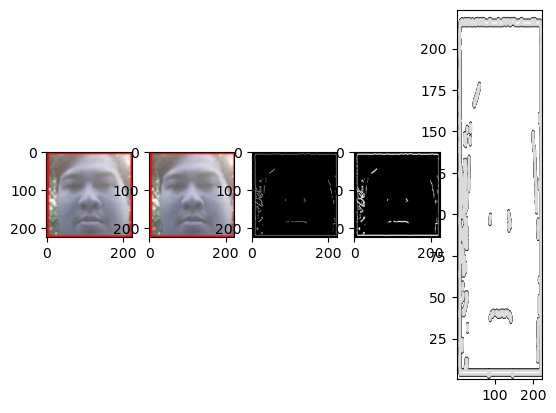

In [53]:
from matplotlib import pyplot as plt

path = '../../datasets/to_train/preprocessed/1917051029/face_1917051029_20221229_Datang Terlambat_66.png'

image = cv2.imread(path, cv2.IMREAD_COLOR)

gray = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)

edge = cv2.Canny(gray, 128,128)

kernel = np.ones((3))
delate = cv2.dilate(edge, kernel, iterations=1)

hu = cv2.HuMoments(cv2.moments(delate)).flatten()

contour = cv2.findContours(delate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.subplot(1,5,1)
plt.imshow(image)

plt.subplot(1,5,2)
plt.imshow(tf.squeeze(gray))

plt.subplot(1,5,3)
plt.imshow(edge, cmap="gray")

plt.subplot(1,5,4)
plt.imshow(delate, cmap="gray")

plt.subplot(1,5,5)
plt.contour(delate, cmap="gray", origin="image")

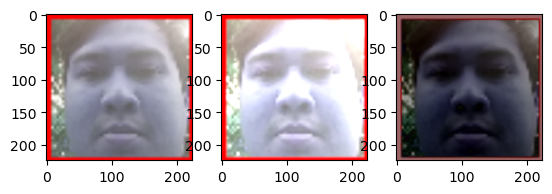

In [68]:
path = '../../datasets/to_train/preprocessed/1917051029/face_1917051029_20221229_Datang Terlambat_66.png'

image = cv2.imread(path, cv2.IMREAD_ANYCOLOR)
change = cv2.convertScaleAbs(image, alpha=1.5)
change2 = cv2.convertScaleAbs(image, beta=-100)

plt.subplot(1,3,1)
plt.imshow(image)

plt.subplot(1,3,2)
plt.imshow(change)
plt.subplot(1,3,3)
plt.imshow(change2)

47
